In [1]:
import numpy as np
import os
import shutil
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.core.debugger import Tracer

from reader import Box, box_iou, anchors
from predict import get_pred_func, predict_image

In [2]:
def average_precision(class_name, pred_file, gt_file, plot=False, iou_th = 0.5, verbose=False):
    """
    Calculate average precision for some specific class, given the ground truth and the predict boxes.

    Args:
        pred_file: path of the file containing the predicted boxes for this specific class.
            Each line in the file is a predicted box, and has the format of 'img_id conf xmin ymin xmax ymax'.
            This format is the submit guideline of VOC2007 and VOC2012
        gt_file: path of the ground truth boxes for this specific class.
        plot: whether plot the precision-recall curve.

    Returns:
        The calculated average precition.

    """
    # load results
    with open(pred_file) as f:
        content = f.readlines()
    records = []
    for line in content:
        record = line.split(' ')
        record[1:] = [float(num) for num in record[1:]]
        
        records.append(record)
    records = sorted(records, key=lambda record: -record[1])
    
    with open(gt_file) as f:
        content = f.readlines()
    gt_records = []
    gt_box_num = 0
    for line in content:
        gt_record = line.split(' ')
        gt_record[1:] = [float(num) for num in gt_record[1:]]
        gt_box_num += (len(gt_record) - 1) / 4
        gt_records.append(gt_record)
    
    tp = np.zeros(len(records))
    fp = np.zeros(len(records))
    
    image_id_list = [gt_record[0] for gt_record in gt_records]

    # for each predict box, set tp or fp based on the maximum iou with ground truth box
    for idx, record in enumerate(records):
        
        # find ground truth image
        if record[0] not in image_id_list:
            fp[idx] = 1
            continue
        
        for gt_idx, gt_record in enumerate(gt_records):
            if gt_record[0] == record[0]:
                break

        # the predicted box
        pred_xmin = record[2]
        pred_ymin = record[3]
        pred_xmax = record[4]
        pred_ymax = record[5]
        
        pred_x = (pred_xmin + pred_xmax) / 2
        pred_y = (pred_ymin + pred_ymax) / 2
        pred_w = pred_xmax - pred_xmin
        pred_h = pred_ymax - pred_ymin
        pred_box = Box(pred_x, pred_y, pred_w, pred_h)
        
        max_iou = -1
        gt_tgt_idx = -1
        i = 1
        gt_box_idx = 0
        while i < len(gt_record):
            gt_xmin = gt_record[i]
            gt_ymin = gt_record[i+1]
            gt_xmax = gt_record[i+2]
            gt_ymax = gt_record[i+3]
            
            gt_x = (gt_xmin + gt_xmax) / 2
            gt_y = (gt_ymin + gt_ymax) / 2
            gt_w = gt_xmax - gt_xmin
            gt_h = gt_ymax - gt_ymin
            
            gt_box = Box(gt_x, gt_y, gt_w, gt_h)
            
            iou = box_iou(pred_box, gt_box)
            
            if iou > max_iou:
                max_iou = iou
                gt_tgt_idx  = gt_box_idx
                
            gt_box_idx += 1
            i += 4

        if max_iou > iou_th:
            tp[idx] = 1
            # remove the gt_tgt from the gt_record, since each ground record can match at most one predict box
            tmp = gt_record[0:1+gt_tgt_idx*4]
            tmp.extend(gt_record[1+(gt_tgt_idx+1)*4:])
            assert(len(gt_record) - len(tmp) == 4)
            gt_record = tmp
            gt_records[gt_idx] = gt_record
        else:
            fp[idx] = 1
            
    tp = np.cumsum(tp)
    fp = np.cumsum(fp)
    
    rec = np.asarray(tp / gt_box_num)
    prec = np.asarray(tp / (fp + tp))
    
    if plot == True:
        plt.plot(rec, prec,'-');
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.title('Recall-Precision Curve')
        plt.grid(True)
        plt.axis([0, 1.05, 0, 1.05])
        
    ap = 0
    for t in range(101):
        v = t / 100
        tmp = prec[rec >= v]
        if len(tmp) == 0:
            p = 0
        else:
            p = np.max(tmp)
        ap = ap + p / 101;

    if verbose:
        print("Ground truth box: " + str(gt_box_num))

        print("True Positive (" + str(len(tp)) + "): ")
        print(tp)
        print("False Positive (" + str(len(fp)) + "): ")
        print(fp)

        print("Recall: ")
        print(rec)
        print("Precision: ")
        print(prec)
        
    print(class_name + ": " + str(ap))

    return ap

In [3]:
# calculate the mAP for a trained model, given:
# 1. the test images txt file
# 2. the trained model path
# 3. the class definitions


classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train","tvmonitor"]

classes_num = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5,
    'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11,
    'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16,
    'sofa': 17, 'train': 18, 'tvmonitor': 19}

test_filepath = "voc_2007_test_without_diff.txt"
# test_filepath = "voc_2007_train.txt"

In [4]:
# generate the test images txt file


gt_dir = "result_gt"

# generate the ground truth files for calculation of average precision
gt_all = {}
with open(test_filepath) as f:
    content = f.readlines()

for line in content:
    record = line.split(' ')
    image_id = os.path.basename(record[0]).split('.')[0]
    i = 1
    
    gt_cur_img = {}
    while i < len(record):
        class_num = int(record[i + 4])
        class_name = classes_name[class_num]
        
        if class_name not in gt_cur_img.keys():
            gt_cur_img[class_name] = []
        gt_cur_img[class_name].extend(record[i:i+4])
        
        i += 5
    
    for class_name, boxes in gt_cur_img.items():
        if class_name not in gt_all:
            gt_all[class_name] = []
        d = [image_id]
        d.extend(boxes)
        gt_all[class_name].append(d)
        
# for class_name, gt_images in gt_all.items():
if os.path.isdir(gt_dir):
    shutil.rmtree(gt_dir)
os.mkdir(gt_dir)
for class_name in classes_name:
    if class_name in gt_all.keys():
        with open(os.path.join(gt_dir, class_name), 'w') as f:
            for line in gt_all[class_name]:
                line = [str(ele) for ele in line]
                f.write(' '.join(line) + '\n')

In [5]:
# generate the predict images txt file
pred_dir = "result_pred"

if os.path.isdir(pred_dir):
    shutil.rmtree(pred_dir)
os.mkdir(pred_dir)

# predict_func = get_pred_func("train_log/VOC_07+12_2/model-558360")
# predict_func = get_pred_func("model-687144")
predict_func = get_pred_func("train_log/train/model-1980540")

[0504 20:22:53 @common.py:94] conv1_1 input: [None, 3, None, None]
[0504 20:22:53 @common.py:102] conv1_1 output: [None, 32, None, None]
[0504 20:22:53 @common.py:94] pool1 input: [None, 32, None, None]
[0504 20:22:53 @common.py:102] pool1 output: [None, 32, None, None]
[0504 20:22:53 @common.py:94] conv2_1 input: [None, 32, None, None]
[0504 20:22:53 @common.py:102] conv2_1 output: [None, 64, None, None]
[0504 20:22:53 @common.py:94] pool2 input: [None, 64, None, None]
[0504 20:22:53 @common.py:102] pool2 output: [None, 64, None, None]
[0504 20:22:53 @common.py:94] conv3_1 input: [None, 64, None, None]
[0504 20:22:53 @common.py:102] conv3_1 output: [None, 128, None, None]
[0504 20:22:53 @common.py:94] conv3_2 input: [None, 128, None, None]
[0504 20:22:53 @common.py:102] conv3_2 output: [None, 64, None, None]
[0504 20:22:53 @common.py:94] conv3_3 input: [None, 64, None, None]
[0504 20:22:53 @common.py:102] conv3_3 output: [None, 128, None, None]
[0504 20:22:53 @common.py:94] pool3 inpu

In [13]:
with open(test_filepath) as f:
    content = f.readlines()

anchors = [[0.738768,0.874946],  [2.42204,2.65704],  [4.30971,7.04493],  [10.246,4.59428],  [12.6868,11.8741]]

for class_name in classes_name:
    with open(os.path.join(pred_dir, class_name), 'w') as f:
        continue

print("Number of images to predict: " + str(len(content)))
        
for image_idx, line in enumerate(content):
    
    if image_idx % 100 == 0 and image_idx > 0:
        print(str(image_idx))
    
    record = line.split(' ')
    image_path = record[0]
    image_id = os.path.basename(image_path).split('.')[0]

    pred_results, image_result = predict_image(image_path, predict_func, anchors, classes_name, det_th=0.001, nms=False)

    for class_name in pred_results.keys():
        with open(os.path.join(pred_dir, class_name), 'a') as f:
            for box in pred_results[class_name]:
                record = [image_id]
                record.extend(box)
                record = [str(ele) for ele in record]
                f.write(' '.join(record) + '\n')

Number of images to predict: 4952
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [14]:
aps = []
for class_name in classes_name:
    aps.append(average_precision(class_name,
                                 os.path.join(pred_dir, class_name),
                                 os.path.join(gt_dir, class_name),
                                 plot=False))

aeroplane: 0.257364527473
bicycle: 0.333550033824
bird: 0.188888940915
boat: 0.0900868472036
bottle: 0.0692321530626
bus: 0.335844964423
car: 0.281753462142
cat: 0.410169008419
chair: 0.0994628351153
cow: 0.169719899505
diningtable: 0.195448001802
dog: 0.36799332702
horse: 0.355031329034
motorbike: 0.292192784088
person: 0.257482275817
pottedplant: 0.0666344077446
sheep: 0.170631151957
sofa: 0.268446103135
train: 0.39739599843
tvmonitor: 0.241861830143


In [15]:
np.mean(aps)

0.24245949406262174

Ground truth box: 657.0
True Positive (42585): 
[   0.    1.    1. ...,  205.  205.  205.]
False Positive (42585): 
[  1.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   4.23780000e+04
   4.23790000e+04   4.23800000e+04]
Recall: 
[ 0.          0.00152207  0.00152207 ...,  0.31202435  0.31202435
  0.31202435]
Precision: 
[ 0.          0.5         0.33333333 ...,  0.00481413  0.00481401
  0.0048139 ]
bottle: 0.0692321530626


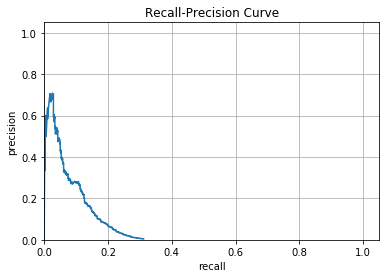

In [16]:
ret = average_precision("bottle",
                        os.path.join(pred_dir, "bottle"),
                        os.path.join(gt_dir, "bottle"),
                        plot=True,
                        iou_th = 0.5,
                        verbose=True)

In [17]:
ret

0.069232153062610741

Ground truth box: 396.0
True Positive (15024): 
[   1.    2.    3. ...,  315.  315.  315.]
False Positive (15024): 
[     0.      0.      0. ...,  14707.  14708.  14709.]
Recall: 
[ 0.00252525  0.00505051  0.00757576 ...,  0.79545455  0.79545455
  0.79545455]
Precision: 
[ 1.          1.          1.         ...,  0.02096925  0.02096785
  0.02096645]
sofa: 0.268446103135


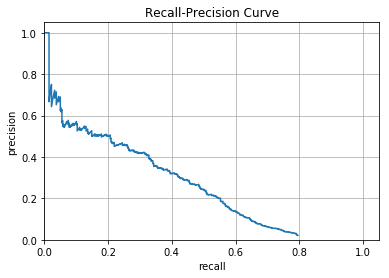

In [18]:
ret = average_precision("sofa",
                        os.path.join(pred_dir, "sofa"),
                        os.path.join(gt_dir, "sofa"),
                        plot=True,
                        iou_th = 0.5,
                        verbose=True)

In [76]:
pred_results, image_result = predict_image("demo/eagle.jpg",
#                                            "VOC2007/JPEGImages/005635.jpg",
                                           predict_func, anchors,
                                           classes_name,
                                           det_th=0.5,
                                           nms=True)

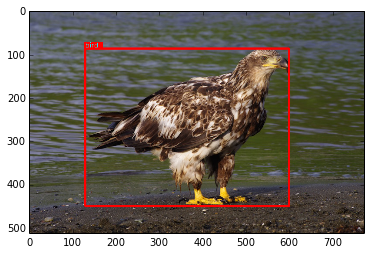

In [77]:
plt.imshow(image_result)

In [74]:
image_result = cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB)

In [75]:
cv2.imwrite("output.png", image_result)

True